# Bank account fraud classification

In [241]:
import pandas as pd
import matplotlib as plt
import numpy as np

from sklearn.preprocessing import StandardScaler # For z-score normalizing the Pandas dataframe
from sklearn.feature_selection import VarianceThreshold # VarianceThreshold used to get rid of columns that hold no variance thus contributing no new information
from imblearn.over_sampling import SMOTE # Use for oversampling the data (generate synthetic data for fraud) to address imbalanced data
from imblearn.under_sampling import RandomUnderSampler # Use for undersampling the data (simply take an equal amount of both classes) to address imbalanced data
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 1. Data exploration

In [242]:
df = pd.read_csv("Base.csv")
pd.set_option('display.max_columns', 70) # Want to be able to see all the columns, and prepare to be able to see columns that are one hot encoded

#### There are non-quantitative variables that need to be processed

In [243]:
# Display the first 5 rows to get a look at the columns
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [271]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

#### Following plot shows that the number of fraud data points is about 1% of the entire dataset, thus, accuracy is not a good indicator of model performance

<AxesSubplot: >

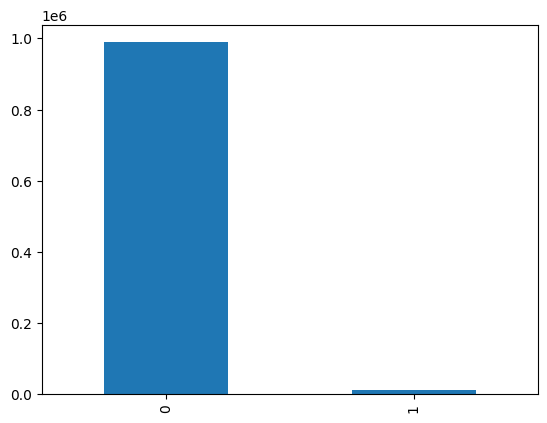

In [244]:
df['fraud_bool'].value_counts().plot(kind='bar') # This is an extremely imbalanced dataset

In [245]:
df.info() # Get information about the variables and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [246]:
df.nunique() # Check how many unique values each of these columns have

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

In [247]:
df.describe(include=["object", "bool"]) # Get basic statistical information about the columns that aren't quantitative

,payment_type,employment_status,housing_status,source,device_os
count,1000000,1000000,1000000,1000000,1000000
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,370554,730252,372143,992952,342728


In [248]:
nan_map = df.isna().sum() # Check for NaN values, there shouldn't be any since this is a synthetic dataset but want to make sure
nan_map

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

#### Note: I won't attempt to remove outliers as the entire point of a dataset like this is likely to explore the defining features of outliers. A technique like Isolation Forest is supposed to do just that

## 2. Data Preprocessing

### One hot encode categorical features

Create new columns for each categorical feature, using a 1 to represent it's presence in a row and 0 to represent the fact that it's not there. We need to do this to have a numeric value for these columns as most models rely on numerical data.

So if a categorical column has 3 values, create 3 columns that are one hot encoded for each of the 3 values

In [249]:
qualitative = [i for i in df.columns if df[i].dtypes == "object"]

print(qualitative)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [250]:
df = pd.DataFrame(pd.get_dummies(df, prefix=qualitative)) # One hot encode the qualitative features using panda's get_dummies method

In [251]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


### Use VarianceThreshold to see if there are features we should remove

If it has no variance then we should drop it from the dataset since they don't contribute any meaningful information but just add more redundancy to the dataset

In [252]:
variance = VarianceThreshold()
variance.fit(df)
features_to_remove = [f for f in df.columns if f not in df.columns[variance.get_support()]] # Go through all original dataframe columns and see if they are in the columns of variance.get_support, which gets the features selected that has a variance

print(features_to_remove)

['device_fraud_count']


In [253]:
df = df.drop(['device_fraud_count'], axis=1) # Drop device_fraud_count since it contains no variance
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


#### Create the training and test data

In [254]:
# First split the data into the features and the true labels for each row
X = df.drop('fraud_bool', axis=1)
Y = df['fraud_bool']
X.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
4,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [255]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Address imbalanced data with SMOTE: Synthetic Minority Over-sampling Technique

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address imbalanced datasets. It generates synthetic examples to help balance the distribution of classes in a dataset, thereby improving the performance of machine learning models that are sensitive to class imbalance.

### How SMOTE Works

1. **Identify Nearest Neighbors**:
   - For each sample in the minority class, SMOTE identifies a set number of nearest neighbors from the same class.

2. **Generate Synthetic Samples**:
   - Synthetic samples are created by interpolating between the original sample and one of its nearest neighbors. The synthetic sample is calculated by taking a linear combination of the two samples.
   - The formula to generate a synthetic sample is: `synthetic` = sample + λ x (neighbor−sample)
   where:
     - `λ` is a random value between 0 and 1,
     - `sample` is the original minority class sample,
     - `neighbor` is one of its identified nearest neighbors.

3. **Balancing the Dataset**:
   - The process is repeated to generate enough synthetic samples to balance the classes.

Increases Diversity: By generating synthetic samples through interpolation, SMOTE creates a more diverse set of samples, reducing the risk of overfitting.
Balances the Dataset: It helps to achieve a more balanced dataset, improving the performance of machine learning algorithms, especially those sensitive to class imbalance.
Preserves Distribution: Since SMOTE interpolates between existing samples, it tends to maintain the general distribution and structure of the minority class.

Noise Sensitivity: If the minority class contains noise or outliers, SMOTE may propagate this noise into the synthetic samples.
Boundary Effects: SMOTE could generate synthetic samples that cross class boundaries, especially if the dataset has overlapping classes.
Parameter Tuning: Selecting the number of nearest neighbors (k) and the number of synthetic samples to generate can require careful tuning.


In [262]:
# Apply oversampling with SMOTE
smote = SMOTE(random_state=42)
X_smote, Y_smote = smote.fit_resample(X_train, Y_train)

In [265]:
print(len(X_smote))
print(len(Y_smote))

1582160
1582160


### Address the data imbalance with UNDER sampling

Basically just sample less from the negative dataset (non fraud) to balance it out against the oversampled data

In [272]:
under_sampler = RandomUnderSampler(random_state=42)
X_under, Y_under = under_sampler.fit_resample(X_train, Y_train)

In [273]:
print(len(X_under))
print(len(Y_under))

17840
17840


### Z-score normalize the data

Normalize the data to prevent one feature from holding too much weight over others

In [266]:
z_score_normalizer = StandardScaler()
X_train_smote = z_score_normalizer.fit_transform(X_smote)
X_test_smote = z_score_normalizer.transform(X_test)

In [ ]:
z_score_normalizer = StandardScaler()
X_train_smote = z_score_normalizer.fit_transform(X_smote) # For some reason couldn't get it to work if I just explicitly said "df = z_score_norm.fit...(df)", had to manually grab the columns in a list
X_test_smote = z_score_normalizer.transform(X_test)

## 3. Training models

In [267]:
LR_smote = LogisticRegression(class_weight='balanced')  # Example with logistic regression
LR_smote.fit(X_train_smote, Y_smote)

LogisticRegression(class_weight='balanced')

In [268]:
Y_pred = LR_smote.predict(X_test_smote)
print(classification_report(Y_pred, Y_test))
print(confusion_matrix(Y_pred, Y_test))
print(f1_score(Y_pred, Y_test))
print(roc_auc_score(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    197645
           1       0.18      0.16      0.17      2355

    accuracy                           0.98    200000
   macro avg       0.58      0.58      0.58    200000
weighted avg       0.98      0.98      0.98    200000

[[195912   1733]
 [  1979    376]]
0.16845878136200718
0.5754460255710567
